# Lending Club Loan Default

In this tutorial, we will go through a step-by-step workflow to determine loan deliquency. We will make predictions based only on the information available at the time the loan was issued.  The data for this exercise come from the public Lending Club data set, a description can be found [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook).

## Workflow

1. Start the Sparkling Water cluster
2. Import data
3. Clean data
4. Feature engineering
5. Model training
6. Examine model accuracy
7. Interpret model
8. Save and reuse model
9. AutoML (optional)
10. Stop the Sparkling Water cluster

# Step 1 (of 10). Start the Sparkling Water cluster

We will begin by starting the Sparkling Water cluster and importing the data into our H2O cluster.

In [1]:
#Initiate H2OContext on top of Spark
from pysparkling import *
hc = H2OContext.getOrCreate()

import h2o

Connecting to H2O server at http://e186a4c45c98:54323/h2o ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.1
H2O_cluster_version_age:,12 days
H2O_cluster_name:,sparkling-water-h2o_local-1603296642320
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.011 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.32.0.1-2-3.0
 * H2O name: sparkling-water-h2o_local-1603296642320
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://e186a4c45c98:54323/h2o (CMD + click in Mac OSX)

    


Note: The method you use for starting and stopping an Sparkling Water cluster will depend on how H2O is installed and configured on your system. Regardless of how H2O is installed, if you start a cluster, you will need to ensure that it is shut down when you are done.

# Step 2 (of 10). Import data

The data set we use below is a local copy of https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/lending/lending_club/LoanStats3a.csv. 

In [2]:
import os
input_csv = "/home/h2o/data/lending_club/LoanStats3a.csv"

if not os.path.exists(input_csv):
    input_csv = "https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/lending/lending_club/LoanStats3a.csv"

### View and Inspect the Data

The loans data set is loaded directly into the H2O-3 cluster using the `h2o.import_file` command:

In [3]:
loans = h2o.import_file(input_csv,
                        col_types = {"int_rate":"string", 
                                     "revol_util":"string", 
                                     "emp_length":"string", 
                                     "verification_status":"string"})

Parse progress: |█████████████████████████████████████████████████████████| 100%


The `h2o.import_file` command loads the data directly into the H2O-3 cluster's memory, bypassing python. If one already has data in python, one can pass that object to a H2O Frame. The `h2o.import_file` approach is incredibly efficient, particularly for larg data sets.

### Inspect the Data with H2O Flow

Now is a good time to connect to H2O Flow. Although H2O Flow can be used for everything from loading data to building models to creating production code, we use it here for data investigation and H2O system monitoring.

**Note**: the reported IP above, `http://localhost`, is the local IP within your particular cloud instance. To open H2O Flow in your own browser, copy the browser URL and

**Aquarium**: 
>Replace 
>```
http://{your URL}/jupyter/
>``` 
>with 
>```
http://{your URL}/h2o/
>```

**Otherwise**: 
>Replace
>```
http://{your URL}:8888
>``` 
>with 
>```
http://{your URL}:54321
>```

Some summary information on the data is provided below:

In [4]:
loans.dim

[42536, 52]

In [5]:
loans.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
1.0775e+06,1.2966e+06,5000,5000,4975,36 months,10.65%,162.87,B,B2,,10+ years,RENT,24000,VERIFIED - income,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0,1985-01-01 00:00:00,1,,,3,0,13648,83.7%,9,f,0,0,5861.07,5831.78,5000,861.07,0,0,0,2015-01-01 00:00:00,171.62,,2015-01-01 00:00:00,0,,1
1.07743e+06,1.31417e+06,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000,VERIFIED - income source,2011-12-01 00:00:00,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1,0,1999-04-01 00:00:00,5,,,3,0,1687,9.4%,4,f,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,2013-04-01 00:00:00,119.66,,2013-09-01 00:00:00,0,,1
1.07718e+06,1.31352e+06,2400,2400,2400,36 months,15.96%,84.33,C,C5,,10+ years,RENT,12252,not verified,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,,small_business,real estate business,606xx,IL,8.72,0,2001-11-01 00:00:00,2,,,2,0,2956,98.5%,10,f,0,0,3003.65,3003.65,2400,603.65,0,0,0,2014-06-01 00:00:00,649.91,,2015-06-01 00:00:00,0,,1
1.07686e+06,1.27718e+06,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20,0,1996-02-01 00:00:00,1,35,,10,0,5598,21%,37,f,0,0,12226.3,12226.3,10000,2209.33,16.97,0,0,2015-01-01 00:00:00,357.48,,2015-01-01 00:00:00,0,,1
1.07536e+06,1.31175e+06,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000,VERIFIED - income source,2011-12-01 00:00:00,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay toward other bills. I've always been a good payor but have found myself needing to make adjustments to my budget due to a medical scare. My job is very stable, I love it.<br>",other,Personal,972xx,OR,17.94,0,1996-01-01 00:00:00,0,38,,15,0,27783,53.9%,38,f,1168.04,1168.04,2767.64,2767.64,1831.96,935.68,0,0,0,2015-06-01 00:00:00,67.79,2015-07-01 00:00:00,2015-06-01 00:00:00,0,,1
1.07527e+06,1.31144e+06,5000,5000,5000,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lend

------

>## Comment: Data preparation for modeling
>
>In this tutorial, we either rush through or perhaps skip steps that a modeler would typically spend a considerable amount of effort on. For example, we omit entirely exploratory data analysis. Additionally, the process of **_defining the problem_** is often iterative and takes a lot of thought and effort. We make the assumption here that this work has already been done by the modeler.
>
>In reality, the majority of a modeler's time is spent on problem definition and data cleaning/wrangling/munging. Our speed at going through these steps to demonstrate the use of H2O-3 in no way minimizes the importance of careful and thoughtful data preparation for model building. 

-----


# Step 3 (of 10).  Clean data


## Part 1. Defining the problem and creating the response variable

The total number of loans in our data set is

In [6]:
num_unfiltered_loans = loans.dim[0]
num_unfiltered_loans

42536

Because we are interested in loan default, we need to look at the `loan_status` column.

In [7]:
loans["loan_status"].table().head(20)

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16


Like many real data sources, `loan_status` is messy and contains multiple, somewhat overlapping, categories. Before modeling, we will need to clean this up by (a) removing loans that are still ongoing, and (b) simplifying the response column.

### (a) Filter Loans

In order to build a valid model, we have to remove loans that are still in process. They have `loan_status` like "Current" and "In Grace Period":

In [8]:
ongoing_status = ["Current",
                  "In Grace Period",
                  "Late (16-30 days)",
                  "Late (31-120 days)",
                  "Does not meet the credit policy.  Status:Current",
                  "Does not meet the credit policy.  Status:In Grace Period"
                 ]
loans = loans[~loans["loan_status"].isin(ongoing_status)]

After filtering out ongoing loans, we now have

In [9]:
num_filtered_loans = loans.dim[0]
num_filtered_loans

38980

loans whose final state is known, which means we filtered out

In [10]:
num_loans_filtered_out = num_unfiltered_loans - num_filtered_loans
num_loans_filtered_out

3556

loans. These loans are now summarized by `loan_status` as

In [11]:
loans["loan_status"].table().head(20)

loan_status,Count
Charged Off,5435
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1933
Fully Paid,30843


### (b) Create Response Column

Let's name our response column `bad_loan`, which will equal one if the loan was not completely paid off.

In [12]:
fully_paid = ["Fully Paid",
              "Does not meet the credit policy.  Status:Fully Paid"
             ]
loans["bad_loan"] = ~(loans["loan_status"].isin(fully_paid))

Next make the `bad_loan` column a factor so that we can build a classification model,

In [13]:
loans["bad_loan"] = loans["bad_loan"].asfactor()

The percentage of bad loans is given by

In [14]:
bad_loan_dist = loans["bad_loan"].table()
bad_loan_dist["Percentage"] = (100 * bad_loan_dist["Count"] / loans.nrow).round()
bad_loan_dist

bad_loan,Count,Percentage
0,32776,84
1,6204,16


## Part 2. Convert strings to numeric

Consider the columns `int_rate`, `revol_util`, and `emp_length`:

In [15]:
loans[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65%,83.7%,10+ years
15.27%,9.4%,< 1 year
15.96%,98.5%,10+ years
13.49%,21%,10+ years
7.90%,28.3%,3 years
18.64%,87.5%,9 years
21.28%,32.6%,4 years
12.69%,36.5%,< 1 year
14.65%,20.6%,5 years
12.69%,67.1%,10+ years


Both `int_rate` and `revol_util` are inherently numeric but entered as percentages. Since they include a "%" sign, they are read in as strings. The solution for both of these columns is simple: strip the "%" sign and convert the strings to numeric.

The `emp_length` column is only slightly more complex. Besides removing the "year" or "years" term, we have to deal with `< 1` and `10+`, which aren't directly numeric. If we define `< 1` as 0 and `10+` as 10, then `emp_length` can also be cast as numeric.

We demonstrate the steps for converting these string variables into numeric values below.

### Convert `int_rate`

In [16]:
loans["int_rate"] = loans["int_rate"].gsub(pattern = "%", replacement = "") # strip %
loans["int_rate"] = loans["int_rate"].trim() # trim whitespace
loans["int_rate"] = loans["int_rate"].asnumeric() # change to numeric 

### Convert `revol_util`

In [17]:
loans["revol_util"] = loans["revol_util"].gsub(pattern="%", replacement="") # strip %
loans["revol_util"] = loans["revol_util"].trim() # trim whitespace
loans["revol_util"] = loans["revol_util"].asnumeric() # change to numeric 

### Convert `emp_length`

In [18]:
# Use gsub to remove " year" and " years"; also translate n/a to "" 
loans["emp_length"] = loans["emp_length"].gsub(pattern="([ ]*+[a-zA-Z].*)|(n/a)", replacement="") 
loans["emp_length"] = loans["emp_length"].trim() # trim whitespace

loans["emp_length"] = loans["emp_length"].gsub(pattern="< 1", replacement="0") # convert "< 1" to 0
loans["emp_length"] = loans["emp_length"].gsub(pattern="10\\+", replacement="10") # convert "10+" to 10
loans["emp_length"] = loans["emp_length"].asnumeric() # trim whitespace

These steps result in

In [19]:
loans[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65,83.7,10
15.27,9.4,0
15.96,98.5,10
13.49,21,10
7.9,28.3,3
18.64,87.5,9
21.28,32.6,4
12.69,36.5,0
14.65,20.6,5
12.69,67.1,10


### Note: Interest rate distributions

Now that we have converted interest rate to numeric, we can use the `hist` function to compare the interest rate distributions for good and bad loans.

Bad Loans


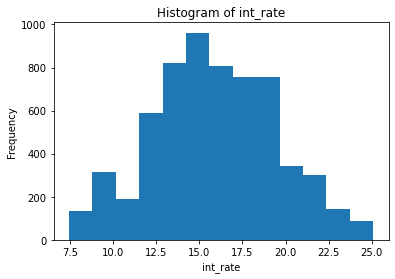

Good Loans


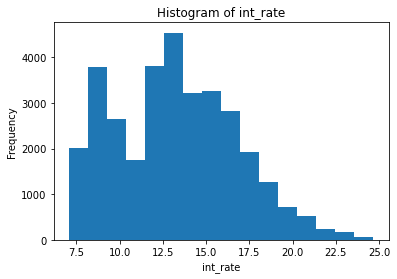

In [20]:
%matplotlib inline

print("Bad Loans")
loans[loans["bad_loan"] == "1", "int_rate"].hist()

print("Good Loans")
loans[loans["bad_loan"] == "0", "int_rate"].hist()

As expected, the bad loan distribution contains proportionately more high interest rate loans than the distribution for good loans. Likewise, the good loan distribution contains a higher proportion of low interest rate loans than that for bad loans. It would not surprise us if interest rate were a strong predictor of loan performance.

>Financial institutions typically set a borrower's interest rate based on factors like estimated risk and customer demand. If the underwriting rules are any good at all, we would expect interest rate to be one of the best predictors of default. 

## Part 3. Clean up messy categorical columns

Much as we did with the `loan_status` column, the `verification_status` column needs cleaning

In [21]:
loans["verification_status"].head()

verification_status
VERIFIED - income
VERIFIED - income source
not verified
VERIFIED - income source
VERIFIED - income source
VERIFIED - income source
VERIFIED - income source
VERIFIED - income
not verified
VERIFIED - income source


Because there are multiple values that mean verified ("VERIFIED - income" and "VERIFIED - income source"), we replace them simply with "verified",

In [22]:
loans["verification_status"] = loans["verification_status"].sub(pattern="VERIFIED - income source", 
                                                                replacement="verified")
loans["verification_status"] = loans["verification_status"].sub(pattern="VERIFIED - income", 
                                                                replacement="verified")
loans["verification_status"] = loans["verification_status"].asfactor()

resulting in

In [23]:
loans["verification_status"].table()

verification_status,Count
not verified,17947
verified,21032


# Step 4 (of 10).  Feature engineering

Now that we have cleaned our data, we can extract information from our current columns to create new features. This process is referred to as _feature engineering_. The general idea is to express information found in our data in a manner that is most understandable to the algorithms we employ, with the goal of improving the performance of our supervised learning models.

Feature engineering can be considered the "secret sauce" in building a superior predictive model: it is often (although not always) more important than the choice of machine learning algorithm. A very good summary of feature engineering recipes can be found in the online [Driverless AI Documentation](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/transformations.html). 

We will do some basic feature engineering using the date fields in our data, and then use NLP (natural language processing) to create word embedding features from the loan description text field in our data.

The new columns we will create are: 
* `credit_length`: the number of years someone has had a credit history
* `issue_d_year` and `issue_d_month`: the year and month from the loan issue date
* word embeddings from the loan description

### Credit Length

We create the `credit_length` feature by subtracting the year of a customer's earliest credit line from the year they were issued the loan.

In [24]:
loans["credit_length"] = loans["issue_d"].year() - loans["earliest_cr_line"].year()
loans["credit_length"].head()

credit_length
26
12
10
15
7
4
7
7
13
22


### Issue Date Expansion

We next extract the year and month from the issue date.  We may find that the month or the year when the loan was issued will impact the probability of a bad loan. Additionally, since months are cyclical we will treat `issue_d_month` as a factor.

In [25]:
loans["issue_d_year"] = loans["issue_d"].year()
loans["issue_d_month"] = loans["issue_d"].month().asfactor()

loans[["issue_d_year", "issue_d_month"]].head()

issue_d_year,issue_d_month
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12


### Word Embeddings

One of the columns in our dataset is a user-provided description of why the loan was requested. The first few descriptions in the dataset are shown below.

In [26]:
loans["desc"].head()

desc
Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>
Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>
""
"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>"
""
Borrower added on 12/16/11 > Downpayment for a car.<br>
Borrower added on 12/21/11 > I own a small home-based judgment collection business. I have 5 years experience collecting debts. I am now going from a home office to a small office. I also plan to buy a small debt portfolio (eg. $10K for $1M of debt) <br>My score is not A+ because I own my home and have no mortgage.<br>
"Borrower added on 12/16/11 > I'm trying to build up my credit history. I live with my brother and have no car payment or credit cards. I am in community college and work full time. Im going to use the money to make some repairs around the house and get some maintenance done on my car.<br><br> Borrower added on 12/20/11 > $1000 down only $4375 to go. Thanks to everyone that invested so far, looking forward to surprising my brother with the fixes around the house.<br>"
"Borrower added on 12/15/11 > I had recived a loan from Citi Financial about a year ago, I was paying 29.99 intrest, so the refinance is to cut that rate since cleaning up my credit I have been paying everything on time as shown on my credit report<br>"
""


The descriptions may contain information that would assist in predicting default, but supervised learning algorithms in general have a hard time understanding text. We need to convert these strings into a numeric representation of the text in order for our algorithms to operate on it. There are multiple choices for doing so, in this example we will use the Word2Vec algorithm.

We start by defining stop words (terms that are considered too frequent to carry much information) 

In [27]:
STOP_WORDS = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what",
              "there","all","we","one","the","a","an","of","or","in","for","by","on",
              "but","is","in","a","not","with","as","was","if","they","are","this","and","it","have",
              "from","at","my","be","by","not","that","to","from","com","org","like","likes","so"]

We next _tokenize_ the descriptions by breaking the text into individual words

In [28]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

words = tokenize(loans["desc"].ascharacter())

Then we train our Word2Vec model on the words extracted from our descriptions. We choose an output vector size of 100.

>What does Word2Vec do? At a high level, it is a dimensionality reduction method for numerical representations of text. But it reduces dimensionality while preserving relationships between words in the text.
>
>Suppose we were to create a dictionary of all the words in our descriptions, and further suppose that dictionary contained 2500 unique words. At one extreme, we could create an indicator variable for each word (i.e., one-hot encoding). This would yield 2500 new features that would certainly lead to massive overfitting of models.
>
>At the other extreme, suppose we had someone classify those words into different groups and create indicator variables for each group: e.g., `risky_words` ("bankruptcy", "default", "forfeit", "lien", etc.), `angry_words` (profanity, "complaint", etc.), and so on. This reduces dimensionality by manually grouping words, but it is extremely labor intensive.
>
>Word2Vec starts with the entire dictionary size $K$ as inputs and the selected vector size $k$ as the target number of outputs. Passing through the intermediate layer(s) of the Word2Vec neural net, a $k$-dimensional numeric representation of each word is derived. 

In [29]:
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size=100, model_id="w2v")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


One way we quickly sanity check the Word2Vec model is by finding synonyms for specified words, e.g., "car"

In [30]:
w2v_model.find_synonyms("car", count=5)

OrderedDict([('auto', 0.7299379706382751),
             ('prius', 0.6815643906593323),
             ('lexus', 0.6762170195579529),
             ('camry', 0.6664002537727356),
             ('tahoe', 0.6482592225074768)])

Assuming we are satisfied with our Word2Vec model results, we next calculate a vector for each description by averaging over all of the words in that description

In [31]:
desc_vecs = w2v_model.transform(words, aggregate_method="AVERAGE")
desc_vecs.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.1569,0.0917783,0.115373,-0.0338863,0.0566152,0.0717367,0.0702481,0.0841752,-0.0581018,0.0159338,0.0765138,0.150959,-0.177845,0.0679589,-0.248922,-0.140308,0.00940761,-0.0554502,0.0763662,0.0960541,0.116275,0.142224,0.0322963,-0.220136,0.0672981,-0.074464,-0.274935,-0.0954874,0.162987,0.0554792,-0.0285099,0.0052118,-0.0593492,-0.146835,-0.10637,-0.0969891,-0.225723,-0.0799466,-0.0106089,0.029022,0.0608748,-0.0733228,0.0494262,-0.0484962,0.120783,-0.0302187,-0.200818,-0.0422789,0.0471193,0.0228818,-0.293265,0.107963,0.0575849,-0.0581704,-0.0691263,0.0554894,-0.139388,0.115562,-0.00504188,-0.229942,-0.177888,-0.000155609,-0.0822879,-0.124496,-0.12607,-0.0213312,0.0873779,-0.128455,0.0142981,-0.0520941,0.0763048,0.171824,0.303564,-0.115806,-0.0447622,-0.0819382,0.0300078,-0.146405,-0.107503,0.0684212,0.108875,0.00217542,-0.147382,0.219772,-0.0589686,-0.0478945,0.0875026,0.0933475,-0.0337898,-0.0260046,-0.0207514,-0.26567,-0.159132,0.0380517,-0.0487481,-0.137535,0.07742,-0.125715,-0.00999652,0.0400608
0.0948749,0.0461954,0.0480034,-0.0980107,0.0218521,0.0585226,0.0283514,0.244356,0.0195643,-0.016414,0.0286203,0.26556,-0.0818991,-0.191218,-0.401958,-0.00167755,0.102813,-0.0383707,-0.0661371,-0.0788671,0.0984475,0.134534,-0.045553,-0.0876101,-0.0235118,0.0347316,-0.352866,0.0345739,0.0505002,-0.00080768,-0.102346,0.0403715,0.044021,-0.154068,-0.0322064,0.0209096,-0.162632,-0.0545294,-0.0363612,-0.0444906,-0.0752263,-0.128192,0.0379584,-0.0527835,0.0196019,-0.0236572,-0.213607,0.0846796,-0.0333762,-0.0244911,-0.141399,0.0835037,0.00526606,0.054355,0.0518191,0.0424563,-0.196715,0.122129,0.00376511,-0.127982,-0.161718,0.0154495,0.0403027,-0.106941,0.0323205,0.0670804,0.0280895,-0.0822464,0.0115271,0.0269277,0.0687513,0.0935805,0.200429,-0.0985836,0.137488,-0.0648057,-0.116537,-0.0433527,0.0203273,-0.0312453,0.0761664,0.00421633,-0.0880803,0.118613,0.0575723,0.0518213,-0.044996,0.022341,-0.0180393,0.0374242,0.000946258,-0.181643,-0.131307,0.0632172,0.0321865,-0.0932442,0.00599087,-0.164194,-0.133889,0.0585286
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.165635,-0.0138259,0.0645425,-0.14433,0.0554321,0.0319883,0.0843239,0.202716,0.130539,-0.0013036,0.0625805,0.227883,-0.0255172,-0.16746,-0.333353,-0.0600507,0.0170636,-0.0367674,0.0580298,0.0185374,0.107334,0.137869,-0.0442438,-0.10906,0.00256357,0.0114266,-0.377248,-0.0136518,0.0359675,-0.130342,-0.121417,0.0907476,-0.0162039,-0.149713,-0.101202,0.0322669,-0.175209,-0.130874,-0.0332644,-0.0119674,-0.0401254,-0.126446,0.0949788,-0.0590565,-0.0470771,0.0568877,-0.245341,0.0202827,0.000372029,0.0742522,-0.166646,0.00755709,-0.00187194,0.0338202,-0.0528059,0.0587954,-0.120495,0.100773,0.0514258,-0.233051,-0.141928,-0.023222,0.0310589,-0.0713709,-0.0211589,0.0709389,0.113068,-0.0586646,-0.0595723,-0.0179191,0.0831639,0.015812,0.15231,-0.057444,0.15354,-0.0391283,-0.0438891,-0.0734277,-0.042335,-0.0888261,-0.0363161,-0.052006,-0.155094,0.217619,0.0239857,-0.0117948,-0.00568971,0.120094,-0.063703,0.0309983,0.0728039,-0.0783737,-0.0826895,0.042425,0.0691523,-0.0532143,0.0599137,-0.145674,-0.0369697,0.0574316
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

Finally, we add the aggregated word embeddings from the Word2Vec model to the loans data

In [32]:
loans = loans.cbind(desc_vecs)

# Step 5 (of 10). Model training

Now that we have cleaned our data and added new columns, we train a model to predict bad loans. First split our loans data into train and test.

In [33]:
train, test = loans.split_frame(seed=25, ratios=[0.75])

Next create a list of predictors as a subset of the columns of the `loans` H2O Frame

In [34]:
cols_to_remove = ["initial_list_status",
                  "out_prncp",
                  "out_prncp_inv",
                  "total_pymnt",
                  "total_pymnt_inv",
                  "total_rec_prncp", 
                  "total_rec_int",
                  "total_rec_late_fee",
                  "recoveries",
                  "collection_recovery_fee",
                  "last_pymnt_d", 
                  "last_pymnt_amnt",
                  "next_pymnt_d",
                  "last_credit_pull_d",
                  "collections_12_mths_ex_med" , 
                  "mths_since_last_major_derog",
                  "policy_code",
                  "loan_status",
                  "funded_amnt",
                  "funded_amnt_inv",
                  "mths_since_last_delinq",
                  "mths_since_last_record",
                  "id",
                  "member_id",
                  "desc",
                  "zip_code"]

predictors = list(set(loans.col_names) - set(cols_to_remove))

In [35]:
predictors

['C35',
 'C91',
 'pymnt_plan',
 'C95',
 'annual_inc',
 'C60',
 'C96',
 'C83',
 'C30',
 'C90',
 'credit_length',
 'C40',
 'emp_title',
 'C8',
 'C28',
 'C81',
 'C64',
 'C66',
 'C59',
 'C52',
 'C69',
 'C99',
 'C68',
 'C1',
 'C78',
 'C72',
 'C94',
 'C33',
 'C100',
 'open_acc',
 'C37',
 'loan_amnt',
 'C82',
 'C24',
 'revol_bal',
 'C46',
 'C76',
 'total_acc',
 'C86',
 'C54',
 'C67',
 'issue_d_year',
 'C32',
 'C14',
 'C27',
 'revol_util',
 'dti',
 'C93',
 'C26',
 'term',
 'issue_d_month',
 'C4',
 'C15',
 'C49',
 'C62',
 'C79',
 'C6',
 'C44',
 'C63',
 'C47',
 'C36',
 'C39',
 'C34',
 'C3',
 'home_ownership',
 'C88',
 'C38',
 'C57',
 'C45',
 'C97',
 'earliest_cr_line',
 'C12',
 'emp_length',
 'C42',
 'C10',
 'C25',
 'C11',
 'C85',
 'C65',
 'pub_rec',
 'C70',
 'C58',
 'C84',
 'C18',
 'C89',
 'C5',
 'C22',
 'C23',
 'C31',
 'C2',
 'C51',
 'C77',
 'C29',
 'C9',
 'grade',
 'url',
 'C55',
 'C48',
 'C75',
 'C80',
 'title',
 'C56',
 'sub_grade',
 'issue_d',
 'inq_last_6mths',
 'C50',
 'C7',
 'C53',
 'ba

Now create an XGBoost model for predicting loan default. This model is being run with almost all of the model-tuning values at their defaults. Later we may want to optimize the hyperparameters using a grid search. 

In [36]:
from h2o.estimators import H2OXGBoostEstimator

param = {
      "ntrees" : 20
    , "nfolds" : 5
    , "seed": 25
}
xgboost_model = H2OXGBoostEstimator(**param)
xgboost_model.train(x = predictors,
                    y = "bad_loan",
                    training_frame=train,
                    validation_frame=test)

Dropping bad and constant columns: [url]


xgboost Model Build progress: |███████████████████████████████████████████| 100%


# Step 6 (of 10).  Examine model accuracy

The plot below shows the performance of the model as more trees are built.  This graph can help us see at what point our model begins overfitting.  Our test data error rate stops improving at around 8-10 trees.

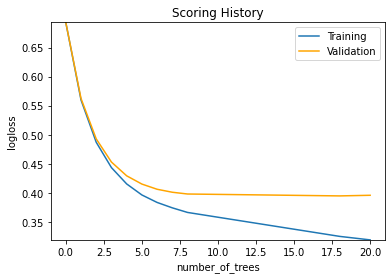

In [37]:
%matplotlib inline
xgboost_model.plot()

The ROC curve of the training and testing data are shown below.  The area under the ROC curve is much higher for the training data than the test data, indicating that the model is beginning to memorize the training data.

Training Data


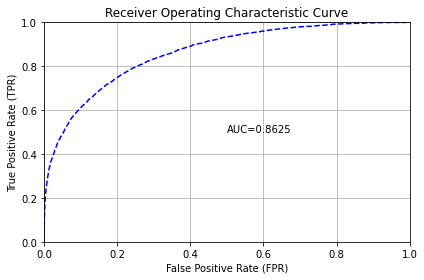

Testing Data


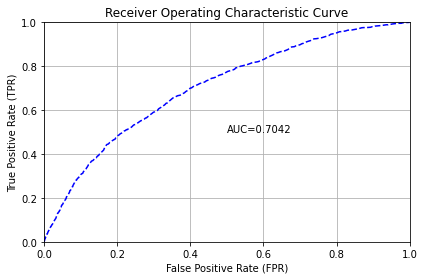

X-Val


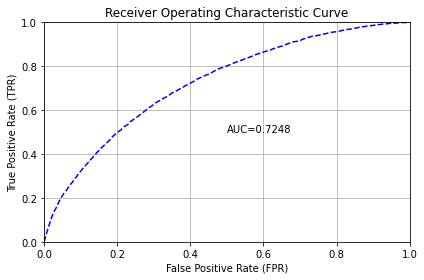

In [38]:
print("Training Data")
xgboost_model.model_performance(train = True).plot()
print("Testing Data")
xgboost_model.model_performance(valid = True).plot()
print("X-Val")
xgboost_model.model_performance(xval=True).plot()

# Step 7 (of 10). Interpret model

The variable importance plot shows us which variables are most important to predicting `bad_loan`.  We can use partial dependency plots to learn more about how these variables affect the prediction.

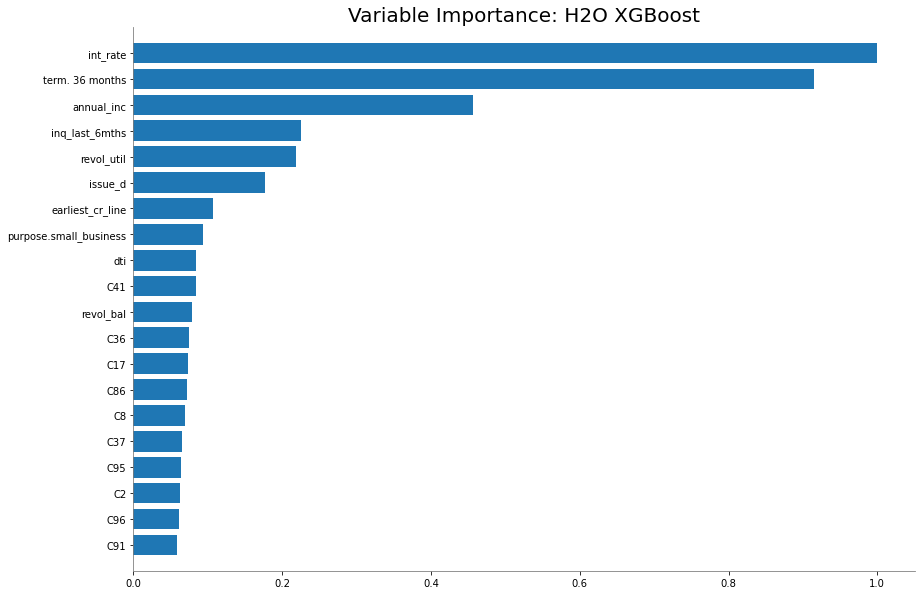

In [39]:
xgboost_model.varimp_plot(20)

As suspected, interest rate appears to be the most important feature in predicting loan default. The partial dependency plot of the `int_rate` predictor shows us that as the interest rate increases, the likelihood of the loan defaulting also increases.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


Since 3.2, the parameter *where* must have the same size as [5.42 6.403684210526316 7.387368421052631 8.371052631578948
 9.354736842105263 10.338421052631578 11.322105263157894 12.30578947368421
 13.289473684210526 14.273157894736842 15.256842105263157
 16.240526315789474 17.224210526315787 18.207894736842107
 19.19157894736842 20.175263157894733 21.158947368421053
 22.142631578947366 23.126315789473686 24.11] in fill_betweenx(). This will become an error two minor releases later.


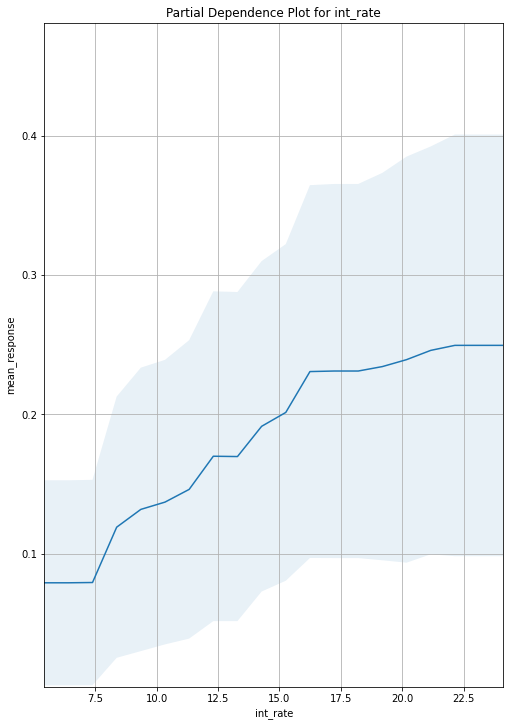

In [40]:
pdp = xgboost_model.partial_plot(cols=["int_rate"], data=train)

# Step 8 (of 10). Save and reuse model

The model can either be embedded into a self-contained Java MOJO package
or it can be saved and later loaded directly into an H2O-3 cluster. For production
use, we recommend using MOJO as it is optimized for speed. See the [guide](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html) for further information.

### Downloading MOJO

In [41]:
xgboost_model.download_mojo()

'/home/h2o/sparkling_water/lending_club_loan_default/XGBoost_model_python_1603296648014_1.zip'

### Save and reuse the model 

We can save the model to disk for later use.

In [42]:
model_path = h2o.save_model(model=xgboost_model, force=True)
print(model_path)

/home/h2o/sparkling_water/lending_club_loan_default/XGBoost_model_python_1603296648014_1


After the H2O cluster shuts down, all unsaved data and models are lost. At some future date, we can load the model for batch scoring in the H2O cluster.

In [43]:
loaded_model = h2o.load_model(path=model_path)

Using that model, we can also score new data with the predict function:

In [44]:
bad_loan_hat = loaded_model.predict(test)
bad_loan_hat.head(15)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.748594,0.251406
0,0.979493,0.0205069
1,0.622163,0.377837
0,0.90005,0.0999497
0,0.929426,0.070574
0,0.931984,0.0680158
0,0.948944,0.0510563
0,0.886569,0.113431
0,0.973249,0.0267509
1,0.748147,0.251853


# Step 9 (of 10). AutoML (optional)

AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit or user specified model build limit. 

Stacked Ensembles will be automatically trained on collections of individual models to produce highly predictive ensemble models.

In [45]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=5, 
                max_runtime_secs_per_model=60, 
                include_algos = ["GLM", "DRF", "XGBoost", "StackedEnsemble"],
                seed=25)
aml.train(x=predictors, y='bad_loan', training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


_While the AutoML job is running, you can open H2O Flow and monitor the model building process._

Once complete, the leaderboard contains the performance metrics of the models generated by AutoML:

In [46]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20201021_161224,0.741383,0.393713,0.359087,0.330583,0.34821,0.12125
StackedEnsemble_BestOfFamily_AutoML_20201021_161224,0.739951,0.394374,0.356156,0.331362,0.348527,0.121471
GLM_1_AutoML_20201021_161224,0.733424,0.393884,0.349371,0.340162,0.348447,0.121415
XGBoost_3_AutoML_20201021_161224,0.720064,0.402301,0.328538,0.33426,0.352572,0.124307
DRF_1_AutoML_20201021_161224,0.712316,0.403327,0.314285,0.345224,0.352838,0.124495
XGBoost_1_AutoML_20201021_161224,0.695923,0.429133,0.304926,0.358361,0.361591,0.130748
XGBoost_2_AutoML_20201021_161224,0.689866,0.430606,0.297921,0.363385,0.362522,0.131422


Since we provided only the training H2O Frame during training, the models are sorted by their cross-validated performance metrics (AUC by default for classification). We can evaluate the best model (`leader`) on the test data:

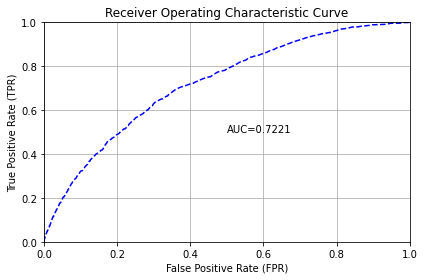


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.1193639172812283
RMSE: 0.3454908353071443
LogLoss: 0.39006646011495494
Null degrees of freedom: 9681
Residual degrees of freedom: 9676
Null deviance: 8292.432037983566
Residual deviance: 7553.246933665988
AIC: 7565.246933665988
AUC: 0.7220678219940094
AUCPR: 0.3245094289753602
Gini: 0.44413564398801886

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14518725640531685: 


,,0,1,Error,Rate
0,0,5696.0,2504.0,0.3054,(2504.0/8200.0)
1,1,536.0,946.0,0.3617,(536.0/1482.0)
2,Total,6232.0,3450.0,0.314,(3040.0/9682.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.145187,0.383617,285.0
1,max f2,0.099034,0.528056,338.0
2,max f0point5,0.323017,0.358784,160.0
3,max accuracy,0.706687,0.848792,20.0
4,max precision,0.881243,1.000000,0.0
5,max recall,0.055791,1.000000,398.0
6,max specificity,0.881243,1.000000,0.0
7,max absolute_mcc,0.145187,0.250323,285.0
8,max min_per_class_accuracy,0.136859,0.663293,292.0
9,max mean_per_class_accuracy,0.131594,0.667223,298.0



Gains/Lift Table: Avg response rate: 15.31 %, avg score: 16.21 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010019,0.642309,3.636963,3.636963,0.556701,0.714044,0.556701,0.714044,0.036437,0.036437,263.696315,263.696315,0.031193
1,2,0.020037,0.571324,2.694047,3.165505,0.412371,0.607694,0.484536,0.660869,0.026991,0.063428,169.404677,216.550496,0.051233
2,3,0.030056,0.520881,2.626696,2.985902,0.402062,0.545817,0.457045,0.622519,0.026316,0.089744,162.669560,198.590184,0.070475
3,4,0.040074,0.476575,2.828749,2.946614,0.432990,0.499888,0.451031,0.591861,0.028340,0.118084,182.874911,194.661366,0.092108
4,5,0.050093,0.444429,2.559344,2.869160,0.391753,0.459075,0.439175,0.565304,0.025641,0.143725,155.934444,186.915981,0.110554
5,6,0.100083,0.331418,2.254177,2.561986,0.345041,0.382084,0.392157,0.473789,0.112686,0.256410,125.417684,156.198566,0.184581
6,7,0.150072,0.267420,1.795243,2.306581,0.274793,0.297145,0.353063,0.414948,0.089744,0.346154,79.524264,130.658055,0.231520
7,8,0.200062,0.221764,1.511783,2.107984,0.231405,0.243261,0.322664,0.372048,0.075574,0.421727,51.178327,110.798381,0.261727
8,9,0.300041,0.163037,1.457791,1.891327,0.223140,0.189716,0.289501,0.311292,0.145749,0.567476,45.779101,89.132748,0.315769
9,10,0.400021,0.132708,1.147336,1.705378,0.175620,0.146735,0.261038,0.270163,0.114710,0.682186,14.733552,70.537752,0.333162


In [47]:
aml.leader.model_performance(test_data=test).plot()
aml.leader.model_performance(test_data=test)

Another convenient use of H2O Flow is to explore the various models built by AutoML.

# Step 10 (of 10). Stop the Sparkling Water cluster

In [48]:
h2o.cluster().shutdown()

H2O session _sid_90ba closed.


Once your work is completed, shutting down the Sparkling Water cluster frees up the resources reserved by H2O.